Postavljanje okruženja

In [1]:
!pip install keras tensorflow
!pip install pandas openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import math
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.dates as mdates
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Diplomski/diplomski/datasets/apple/apple_fund_data.csv'

Mounted at /content/drive


Postavljanje dataseta:

*   Dataset sadržava vrijednosti za svaki radni dan burze od 2015 do 2020
*   Svaki redak sadržava datum i cijenu dionice na taj datum
* Svaki redak također sadržava cijenu dionice i ostale vrijednosti od prošlog radnog dana


In [2]:
data = pd.read_csv(file_path)

features_to_shift = [
  "Adj_Close","Revenue","Net_Income","EPS","Gross_Profit_Margin",
  "Operating_Margin","Net_Profit_Margin","Cash_Flow_From_Operations",
  "Total_Assets","Total_Liabilites","Shareholders_Equity"
]

data['today_price'] = data['Adj_Close']
data[features_to_shift] = data[features_to_shift].shift(1)
data['prediction'] = data['today_price'] -  data['Adj_Close']
data['price_diff'] = data['prediction'].shift(1)

features_to_keep = [
  "Date","Adj_Close","Revenue","Net_Income","EPS","Gross_Profit_Margin",
  "Operating_Margin","Net_Profit_Margin","Cash_Flow_From_Operations",
  "Total_Assets","Total_Liabilites","Shareholders_Equity", "today_price", "price_diff", 'prediction'
]

data = data[features_to_keep]
data.dropna(inplace=True)

data

,Date,Adj_Close,Revenue,Net_Income,EPS,Gross_Profit_Margin,Operating_Margin,Net_Profit_Margin,Cash_Flow_From_Operations,Total_Assets,Total_Liabilites,Shareholders_Equity,today_price,price_diff,prediction
2,2015-01-06,23.746889,74599.0,18024.0,3.08,39.88,32.52,24.19,33722.0,261894.0,138566.0,123328.0,23.749128,-0.688376,0.002239
3,2015-01-07,23.749128,74599.0,18024.0,3.08,39.88,32.52,24.19,33722.0,261894.0,138566.0,123328.0,24.082130,0.002239,0.333002
4,2015-01-08,24.082130,74599.0,18024.0,3.08,39.88,32.52,24.19,33722.0,261894.0,138566.0,123328.0,25.007435,0.333002,0.925305
5,2015-01-09,25.007435,74599.0,18024.0,3.08,39.88,32.52,24.19,33722.0,261894.0,138566.0,123328.0,25.034250,0.925305,0.026815
6,2015-01-12,25.034250,74599.0,18024.0,3.08,39.88,32.52,24.19,33722.0,261894.0,138566.0,123328.0,24.417383,0.026815,-0.616867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2019-12-24,69.082321,64140.0,13686.0,3.08,37.83,24.51,21.24,69391.0,338516.0,248028.0,90488.0,69.147995,1.109215,0.065674
1254,2019-12-26,69.147995,64140.0,13686.0,3.08,37.83,24.51,21.24,69391.0,338516.0,248028.0,90488.0,70.519913,0.065674,1.371918
1255,2019-12-27,70.519913,64140.0,13686.0,3.08,37.83,24.51,21.24,69391.0,338516.0,248028.0,90488.0,70.493164,1.371918,-0.026749
1256,2019-12-30,70.493164,64140.0,13686.0,3.08,37.83,24.51,21.24,69391.0,338516.0,248028.0,90488.0,70.911545,-0.026749,0.418381


Parametri koji će se koristiti kao input (X) varijabla za model
* Lako možemo promijeniti ulazne varijable

In [3]:
indicators_to_keep = [
  "price_diff","Revenue","Net_Income","EPS","Gross_Profit_Margin",
  "Operating_Margin","Net_Profit_Margin","Cash_Flow_From_Operations",
  "Total_Assets","Total_Liabilites","Shareholders_Equity"
]

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [5]:
train_size = int(len(data) * 0.8)

In [6]:
def walk_forward_validation_ann(data):
    actual_values = []
    predicted_values = []
    rmse_values = []
    for i in range(train_size, len(data)):
        train_data = data.iloc[:i+1]
        train_data = train_data[indicators_to_keep]

        scaler_x = MinMaxScaler()
        train_data = scaler_x.fit_transform(train_data)

        test_data = train_data[-1]
        train_data = train_data[:i]


        X_train = train_data
        y_train = data.iloc[:i]["prediction"]
        X_test = test_data
        y_test = data.iloc[i:i+1]["prediction"]

        scaler_y = MinMaxScaler()

        y_train = scaler_y.fit_transform(np.array(y_train).reshape(-1,1))
        y_test = np.array(y_test).reshape(-1,1)

        model = Sequential([
          Dense(256, activation='relu', input_shape=(data[indicators_to_keep].shape[1],)),
          Dense(16, activation='relu'),
          Dense(1)
        ])

        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0, callbacks=[early_stopping])

        X_test = np.array(X_test)
        X_test = X_test[np.newaxis, :]

        prediction = model.predict(X_test)
        prediction = scaler_y.inverse_transform(prediction)

        actual_values.append(y_test)
        predicted_values.append(prediction)
        value = mean_squared_error(y_test, prediction)
        value = np.sqrt(value)
        rmse_values.append(value)

    return predicted_values, actual_values, rmse_values

predicted_values, actual_values, rmse_values = walk_forward_validation_ann(data)

1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 86ms/step


In [7]:
predicted_values = np.concatenate(predicted_values).flatten()
actual_values = np.concatenate(actual_values).flatten()

Grafički prikaz

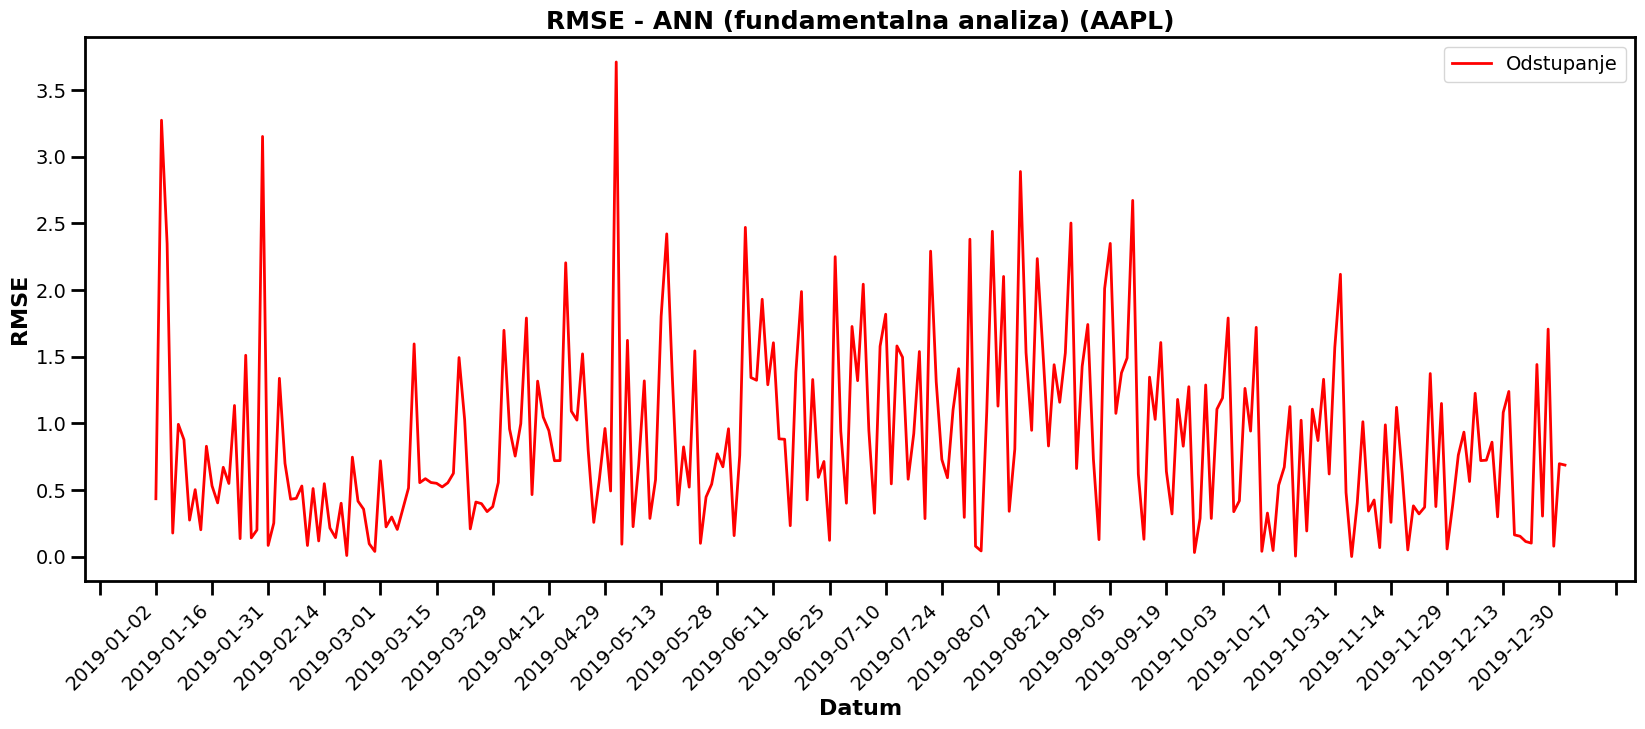

In [8]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot RMSE values with increased line thickness
plt.plot(plot_data["Date"], rmse_values, label='Odstupanje', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('RMSE', fontsize=16, fontweight='bold')
plt.title('RMSE - ANN (fundamentalna analiza) (AAPL)', fontsize=18, fontweight='bold')

# Customize the legend as requested
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


In [9]:
excel = {
    'Date': plot_data["Date"],
    'RMSE': rmse_values
}
df = pd.DataFrame(excel)

# Export to an Excel file
excel_file_path = 'ANN_fund_GOOG_rmse_values.xlsx'
df.to_excel(excel_file_path, index=False)

In [10]:
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
print(rmse)

1.125382140128027


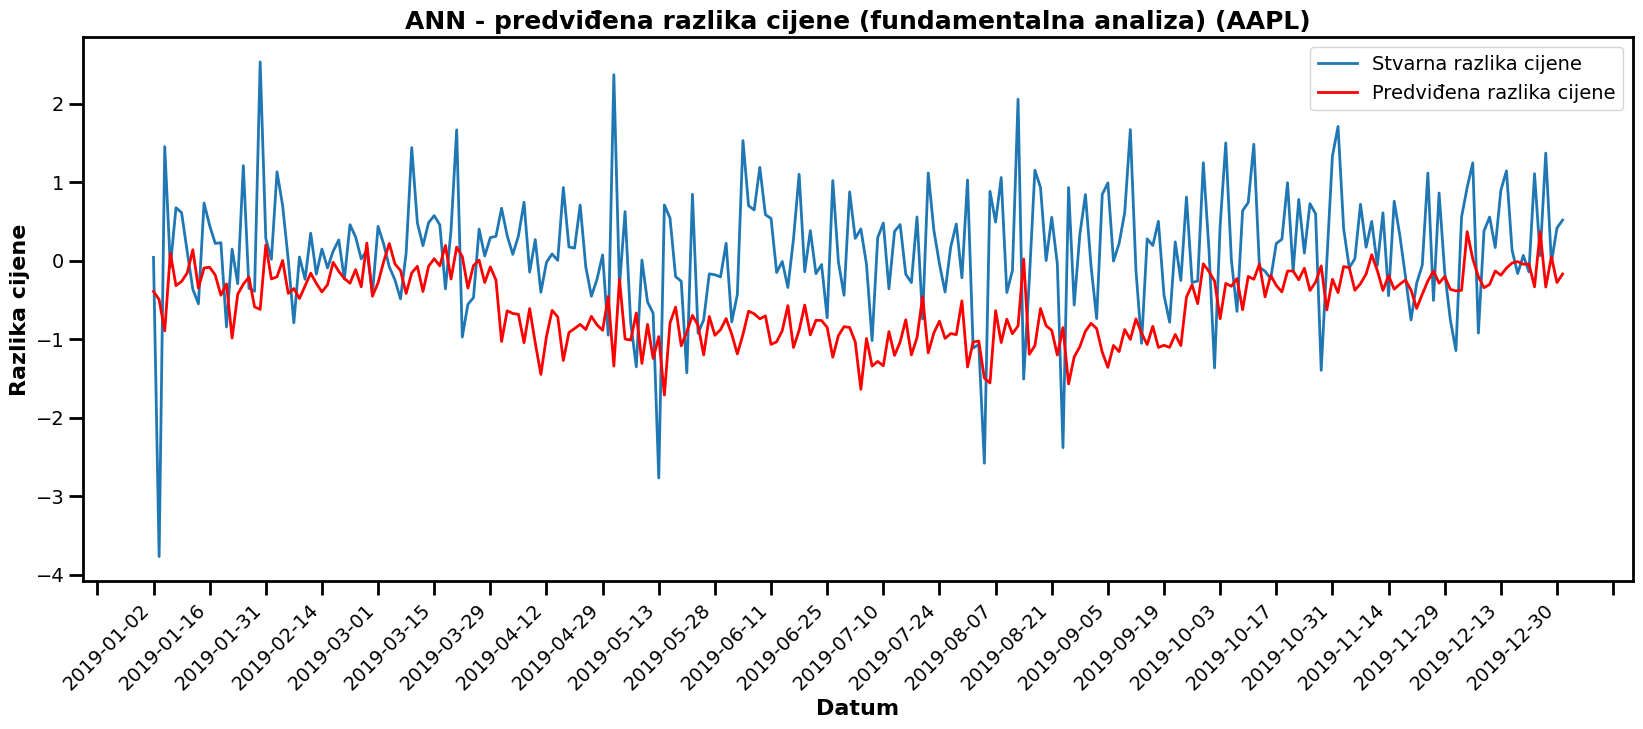

In [11]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot actual and predicted values with increased line thickness
plt.plot(plot_data["Date"], actual_values, label='Stvarna razlika cijene', linewidth=2)
plt.plot(plot_data["Date"], predicted_values, label='Predviđena razlika cijene', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Razlika cijene', fontsize=16, fontweight='bold')
plt.title('ANN - predviđena razlika cijene (fundamentalna analiza) (AAPL)', fontsize=18, fontweight='bold')

# Customize the legend
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


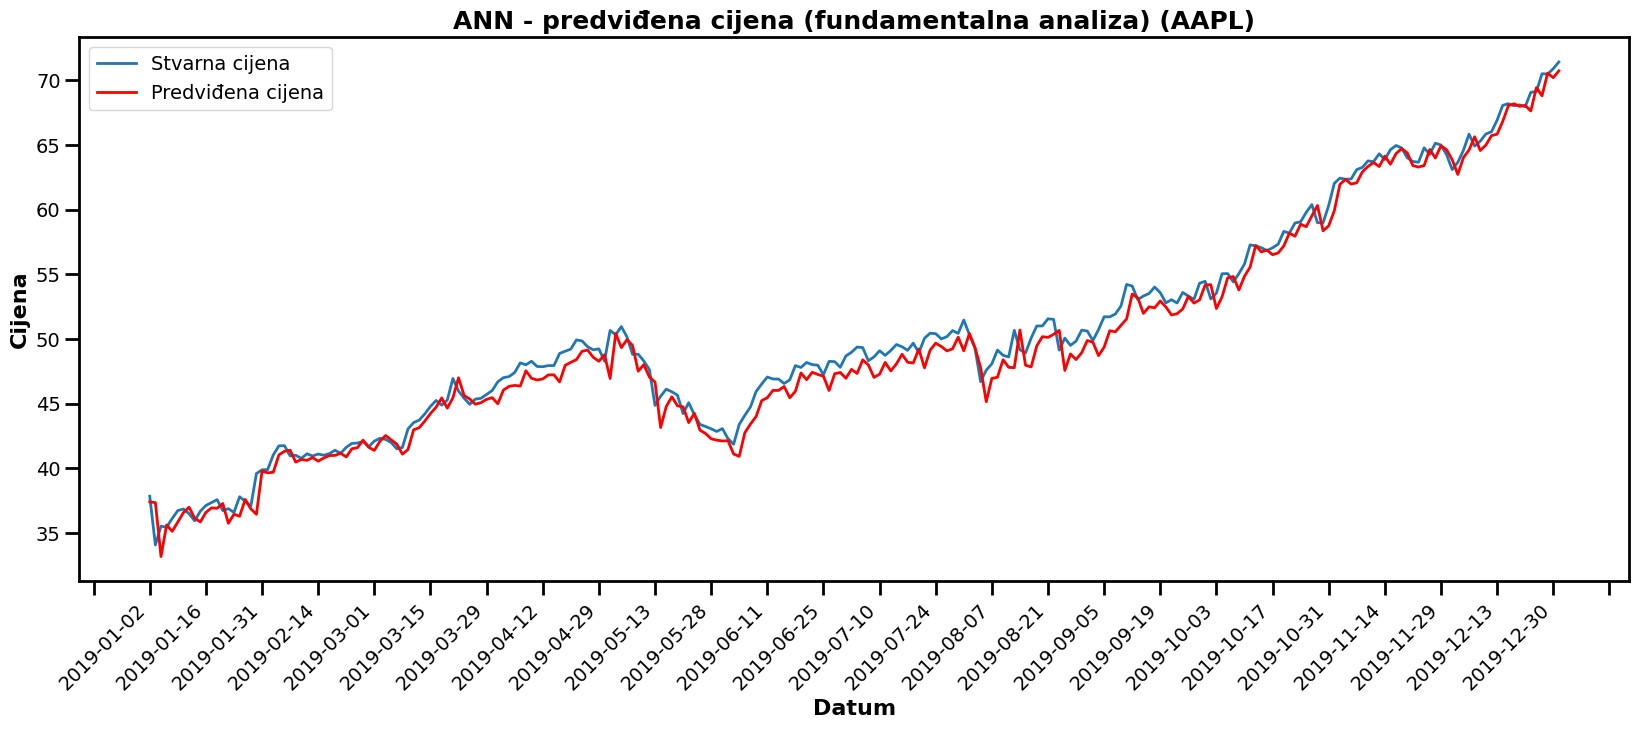

In [12]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plot_data["predicted_diff"] = predicted_values
plot_data["Predicted_price"] = plot_data["Adj_Close"] + plot_data["predicted_diff"]

plt.figure(figsize=(20, 8))

# Plot actual and predicted prices with increased line thickness
plt.plot(plot_data["Date"], plot_data["today_price"], label='Stvarna cijena', linewidth=2)
plt.plot(plot_data["Date"], plot_data["Predicted_price"], label='Predviđena cijena', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Cijena', fontsize=16, fontweight='bold')
plt.title('ANN - predviđena cijena (fundamentalna analiza) (AAPL)', fontsize=18, fontweight='bold')

# Customize the legend
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()
